# TODO: add a column for referential or substantive controls to the base dataset and the one with embeddings

***

# Embeddings

- By [Zachary Kilhoffer](https://zkilhoffer.github.io/)
- Updated 2024-06-17

***

### Description
- The code is part of the pipelines described in: 
  - Kilhoffer, Z. et al. (2024 in press). "Cloud Privacy Beyond Legal Compliance: An NLP analysis of certifiable privacy and security standards".
- The paper will be released on 2024-06-28 at the [IEEE Cloud Summit](https://www.ieeecloudsummit.org/2024-program).

***

- This is a pipeline to create embeddings from texts using a pre-trained LLMs. 
- You can easily repeat this process with a different LLM than BERT, adding the embeddings as a new column.
- This can be useful, for example, for a one-shot learning topic model pipeline using BERTopic for models A, B, and C (using different embeddings), then visualize and compare results as needed.

***

### Input files:
 - df = pd.read_excel('df_noembeddings_github.xlsx')

### Output files:
- 'df_embeddings_2023-12-16.xlsx'
- 'reference_only_df_embeddings_2023-12-16.xlsx'

***

In [47]:
! pip freeze > requirements_embeddings.txt

In [1]:
import warnings
import pandas as pd
# import numpy
# import torch
# import openpyxl
from transformers import BertTokenizer, BertModel, pipeline
from bertopic import BERTopic
# import matplotlib
import matplotlib.pyplot as plt
# from sentence_transformers import SentenceTransformer

/Users/Zak/Desktop/privacy-standard-topic-modeling/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [2]:
# display tweaks
pd.set_option("display.max_colwidth", 200)  # how much text is showing within a cell
pd.set_option("display.max_columns", False)
pd.set_option("display.max_rows", False)
warnings.filterwarnings("ignore")

In [5]:
# load data
df = pd.read_excel('../data/df_noembeddings_github.xlsx', index_col=0)

In [8]:
# inspect df
df.head(2)

,control_category,control_code,control_name,document,control_text_corrected,full_control_text
121,audit & assurance,A&A-01,audit and assurance policy and procedures,ccm,"Establish, document, approve, communicate, apply, evaluate, and maintain audit and assurance policies and procedures and standards. Review and update the policies and procedures at least annually....","Audit & assurance. Audit and assurance policy and procedures. Establish, document, approve, communicate, apply, evaluate, and maintain audit and assurance policies and procedures and standards. Re..."
122,audit & assurance,A&A-02,independent assessments,ccm,Conduct an independent audit and assurance assessment according to relevant standards at least annually. The independent audit and assurance should be free from conflicts of interest and undue inf...,Audit & assurance. Independent assessments. Conduct an independent audit and assurance assessment according to relevant standards at least annually. The independent audit and assurance should be f...


Number of control texts longer than limit: 8.


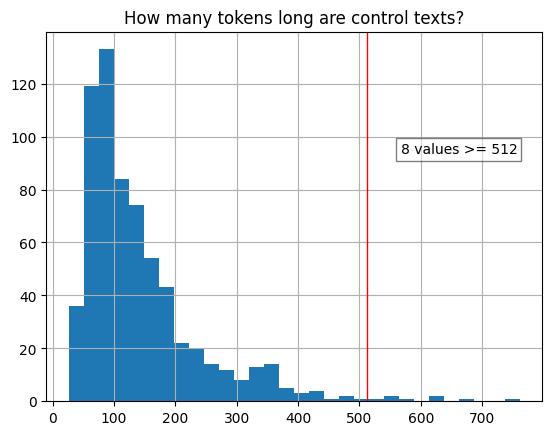

In [7]:
# How long are the texts? 
# BERT embeddings will truncate texts over 512 tokens. 

l = df['full_control_text'].apply(lambda x: len(x.split(' ')))
z = len([x for x in l if x >= 512])
print(f'Number of control texts longer than limit: {z}.')

ax = l.hist(bins=30)  # create histogram using axes object
ax.set_title('How many tokens long are control texts?')
plt.axvline(x=512, color='red', linewidth=1)
props = dict(boxstyle='square', facecolor='white', alpha=0.5)

ax.text(0.95, 0.7, f'{z} values >= 512', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)
plt.show()

In [9]:
# create list for encoding
docs = list(df['full_control_text'].values)

# BERT base

First we create embeddings using "bert-base-uncased", a popular model available on HuggingFace.

Feel free to play around with different models!



In [11]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"  
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# function to do BERT embedding on text
def get_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_input)
    
    # Use the pooler output (representation of [CLS] token) and detach it to convert tensor to numpy
    embedding = output[1].detach().numpy()
    return embedding

In [12]:
# create embeddings for each row based on the text in column "full_control_text"
# this column has the "control category" and "control name" for additional context
df['BERTembeddings'] = df['full_control_text'].apply(get_embedding)

In [14]:
# transform embeddings from embedded list [[num, num]] to simple list [num, num]
df['BERTembeddings'] = df['BERTembeddings'].apply(lambda x: x[0])

In [15]:
# inspect
df.head(2)

,control_category,control_code,control_name,document,control_text_corrected,full_control_text,BERTembeddings
121,audit & assurance,A&A-01,audit and assurance policy and procedures,ccm,"Establish, document, approve, communicate, apply, evaluate, and maintain audit and assurance policies and procedures and standards. Review and update the policies and procedures at least annually....","Audit & assurance. Audit and assurance policy and procedures. Establish, document, approve, communicate, apply, evaluate, and maintain audit and assurance policies and procedures and standards. Re...","[-0.32711124, -0.24001496, -0.9943467, 0.52882636, 0.87031597, -0.3757414, -0.5379881, -0.029107185, -0.9781098, -0.9988584, -0.82185704, 0.9518274, 0.34914154, 0.90948486, -0.26283824, -0.5794722..."
122,audit & assurance,A&A-02,independent assessments,ccm,Conduct an independent audit and assurance assessment according to relevant standards at least annually. The independent audit and assurance should be free from conflicts of interest and undue inf...,Audit & assurance. Independent assessments. Conduct an independent audit and assurance assessment according to relevant standards at least annually. The independent audit and assurance should be f...,"[-0.71023166, -0.40096354, -0.99866545, 0.8446086, 0.9410193, -0.51828206, 0.5187864, 0.13894705, -0.99262995, -0.99993604, -0.9070421, 0.987048, 0.5374107, 0.9503139, -0.060270753, -0.85017586, -..."


In [58]:
# savings results
df.to_excel('../data/df_embeddings_github_test.xlsx')